# example2 — Skin–vessel geometry at a single wavelength (MCXYZ/NMC viewer)

This notebook sets up a **skin–blood-vessel geometry** at a single wavelength, builds tissue optical properties from a spectral library, runs NMC/MCXYZ for that geometry, and visualizes the resulting **reflectance, fluence, and absorption deposition** fields.

**Workflow**

1. Define the working directory (`nmcdir`), basic run controls, and the target wavelength `nm` (and corresponding `λ` in mm).  
2. Construct tissue optical properties μ<sub>a</sub>, μ<sub>s</sub>, g for multiple layers/tissues using `tissue_parameters(nm)` and `spectralLIB.mat`.  
3. Set up a 3D Cartesian grid (Nx, Ny, Nz, binsize) and build the tissue label array `T(y,x,z)` for the skin–vessel model.  
4. Write the input geometry file `<myname>_T.bin` and the run-control file `<myname>_H.mci` for the NMC/MCXYZ solver.  
5. (Optional) Change to the NMC build directory and run the external binary `./nmc <myname>` to generate `<myname>_F.bin` and `<myname>_T.bin` outputs.  
6. Use `look_mcxyz(myname, nm, savepics=True)` to load the output volumes and plot:  
   - Reflectance map R(y,x) at the surface,  
   - Transmittance map T(y,x),  
   - Fluence distribution in a z–x mid-plane,  
   - Absorption deposition in a z–x mid-plane,  
   saving each plot as a PNG if `savepics=True`.  

> If the NMC binary is not present or the output files are missing, the notebook will not produce new MC results but can still be used to visualize any compatible pre-computed data.


In [15]:
import numpy as np
import os,subprocess
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.io import loadmat
from pathlib import Path
import struct
from tqdm import tqdm
import math

In [16]:
nmcdir = Path('../NMC/DerivedData/NMC/Build/Products/Release')
spectralLIB_dir = os.getcwd()
# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

def tissue_parameters(nm, spectral_lib_file: str = "spectralLIB.mat"):
    """
    Returns a dict of tissue optical properties at wavelength nm (in nm).
    Each tissue has keys: 'name', 'mua', 'mus', 'g', 'musp'.
    """

    # --- Load spectral library ---
    spectral_lib_path = os.path.join(spectralLIB_dir, spectral_lib_file)
    print('Spectral library path:', spectral_lib_path)
    data = loadmat(spectral_lib_path)
    muaoxy   = data["muaoxy"].ravel()
    muadeoxy = data["muadeoxy"].ravel()
    muawater = data["muawater"].ravel()
    muamel   = data["muamel"].ravel()
    nmLIB    = data["nmLIB"].ravel().astype(float)

    # Interpolate spectra at nm
    MU = np.zeros(4)
    MU[0] = np.interp(nm, nmLIB, muaoxy)    # oxy-Hb
    MU[1] = np.interp(nm, nmLIB, muadeoxy)  # deoxy-Hb
    MU[2] = np.interp(nm, nmLIB, muawater)  # water
    MU[3] = np.interp(nm, nmLIB, muamel)    # melanin

    def musp_at(musp500, fray, bmie):
        """scattering at nm"""
        x = nm / 500.0
        return musp500 * (fray * x**-4 + (1 - fray) * x**-bmie)

    def mua_mix(B, S, W, M):
        """absorption mix"""
        X = np.array([B * S, B * (1 - S), W, M], dtype=float)
        return float(MU @ X)

    tissue_list = {}

    # 1) Air
    tissue_list[1] = {"name": "air", "mua": 1e-4, "mus": 1.0, "g": 1.0}
    tissue_list[1]["musp"] = tissue_list[1]["mus"] * (1 - tissue_list[1]["g"])

    # 2) Water
    tissue_list[2] = {"name": "water", "mua": MU[2], "mus": 10.0, "g": 1.0}
    tissue_list[2]["musp"] = tissue_list[2]["mus"] * (1 - tissue_list[2]["g"])

    # 3) Blood
    B, S, W, M = 1.00, 0.75, 0.95, 0.0
    musp500, fray, bmie, gg = 10.0, 0.0, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[3] = {
        "name": "blood",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 4) Dermis
    B, S, W, M = 0.002, 0.67, 0.65, 0.0
    musp500, fray, bmie, gg = 43.6, 0.41, 0.562, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[4] = {
        "name": "dermis",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 5) Epidermis
    B, S, W, M = 0.0, 0.75, 0.75, 0.03
    musp500, fray, bmie, gg = 66.7, 0.29, 0.689, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[5] = {
        "name": "epidermis",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 6) Skull
    B, S, W, M = 0.0005, 0.75, 0.35, 0.0
    musp500, fray, bmie, gg = 30.0, 0.0, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[6] = {
        "name": "skull",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 7) Gray matter
    B, S, W, M = 0.01, 0.75, 0.75, 0.0
    musp500, fray, bmie, gg = 20.0, 0.2, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[7] = {
        "name": "gray matter",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 8) White matter
    B, S, W, M = 0.01, 0.75, 0.75, 0.0
    musp500, fray, bmie, gg = 20.0, 0.2, 1.0, 0.90
    musp = musp_at(musp500, fray, bmie)
    tissue_list[8] = {
        "name": "white matter",
        "mua": mua_mix(B, S, W, M),
        "mus": musp / (1 - gg),
        "g": gg,
        "musp": musp,
    }

    # 9) Standard tissue
    tissue_list[9] = {"name": "standard tissue", "mua": 1.0, "mus": 100.0, "g": 0.90}
    tissue_list[9]["musp"] = tissue_list[9]["mus"] * (1 - tissue_list[9]["g"])

    return tissue_list


Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release


In [17]:
# --- assumes tissue_parameters(nm) is defined (the nm-only version from earlier) ---
# from your_module import tissue_parameters

# =========================
# User-defined / from your config
# =========================
SAVEON       = 1
myname       = "skinvessel"
time_min     = 10.0
nm           = 532
lambda_mm    = 532.0e-6;
lc           = 0.001; 
n1           = 1.4
n2           = 1.001

Nbins        = 200
binsize      = 0.0005   # be consistent with your kernel units

# Launch / boundary flags
mckernelflag = 1  # 1=mcxyz
det_state    = 0  # 0-reflectance, 1-transmittance
mcflag       = 0        # 0=uniform, 1=Gaussian, 2=isotropic point, 3=rectangular
launchflag   = 0        # 0=auto launch vector, 1=manual ux0,uy0,uz0
boundaryflag = 2        # 0=no boundaries, 1=escape at boundaries, 2=escape at surface only
zsurf        = 0.0100   # air/skin interface depth
speckleflag  = 0
semiflag     = 1

# Source / focus geometry
xs, ys, zs   = 0.0, 0.0, 0.0101
xfocus, yfocus = 0.0, 0.0
zfocus       = math.inf  # inf -> collimated

# Beam radii (if mcflag in {0,1,3})
radius       = 0.0300
waist        = 0.0300
det_radius   = 15.0;
separation   = 0.0; 
na           = 90.0  # numerical aperture (deg ~ 90 collects all reflectance)
    
# Manual launch vector (if launchflag == 1)
ux0, uy0 = 0.7, 0.4
uz0      = math.sqrt(max(0.0, 1.0 - ux0**2 - uy0**2))


Spectral library path: /Users/aledoronin/Desktop/NMC_framework/NMC-samples/spectralLIB.mat
Tissue library Nt=9 | grid 200x200x200 @ 0.0005 units
x∈[-0.0495,0.0500], z∈[0.0005,0.1000] | zsurf=0.0100
Vessel radius=0.0100 at (x=0.0000, z=0.0500)


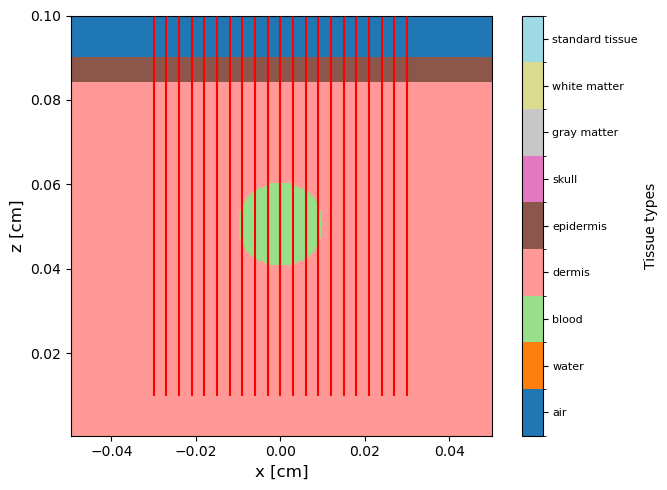

In [18]:
# =========================
# Create tissue optical properties (vectors muav, musv, gv)
# =========================
tp = tissue_parameters(nm)  # dict: 1..9

# Build vectors in index order 1..Nt where Nt = len(tp)
indices = sorted(tp.keys())
Nt = len(indices)

muav = np.zeros(Nt, dtype=float)
musv = np.zeros(Nt, dtype=float)
gv   = np.zeros(Nt, dtype=float)

for i, k in enumerate(indices):
    muav[i] = float(tp[k]["mua"])
    musv[i] = float(tp[k]["mus"])
    # write zeros for g unless USE_G is True
    gv[i]   = float(tp[k]["g"])

# =========================
# Grid and coordinate axes
# =========================
Nx = Ny = Nz = int(Nbins)
dx = dy = dz = float(binsize)

x = (np.arange(1, Nx + 1) - Nx / 2.0) * dx  # center at 0 in x
y = (np.arange(1, Ny + 1) - Ny / 2.0) * dy  # center at 0 in y
z = (np.arange(1, Nz + 1)) * dz             # z starts positive downward

zmin, zmax = float(z.min()), float(z.max())
xmin, xmax = float(x.min()), float(x.max())

# Replace inf focus for file writing compatibility
zfocus_out = 1e12 if math.isinf(zfocus) else float(zfocus)

# =========================
# Build tissue label volume T(y, x, z)
# =========================
# Convention: indices in your tissue list:
# 2 = water/air (you used 2 for "air" in MATLAB)
# 4 = dermis (background)
# 5 = epidermis
# 3 = blood
# Match exactly your MATLAB labeling.
AIR_IDX      = 1
DERMIS_IDX   = 4
EPIDERMIS_IDX= 5
BLOOD_IDX    = 3

T = np.zeros((Ny, Nx, Nz), dtype=np.float64)

# Fill background with dermis
T[...] = DERMIS_IDX

# Air above surface
air_z_limit = int(round(zsurf / dz))
if air_z_limit >= 1:
    T[:, :, :air_z_limit] = AIR_IDX

# Epidermis: 60 μm thick (0.006 cm) starting just below zsurf
epi_z1 = int(round(zsurf / dz))
epi_z2 = int(round((zsurf + 0.0060) / dz))
epi_z1 = max(epi_z1 + 1, 1) 
epi_z2 = min(epi_z2, Nz)
if epi_z2 >= epi_z1:
    T[:, :, epi_z1 - 1:epi_z2] = EPIDERMIS_IDX

# Blood vessel cylinder along y, centered at (xc, zc), radius in x–z plane
xc = 0.0
zc = Nz / 2.0 * dz
vesselradius = 0.0100  # 100 μm

# Precompute x, z distances for speed
X, Z = np.meshgrid(x, z, indexing="xy")  # X: (Nx, Nz), Z: (Nx, Nz)
r = np.sqrt((X - xc) ** 2 + (Z - zc) ** 2)  # (Nx, Nz)
mask_xz = (r <= vesselradius)  # True where inside cylinder

# Paint blood into all y for masked x–z columns
for iz in range(Nz):
    # vectorized over x, set entire y-column for those x that satisfy mask
    x_mask = mask_xz[:, iz]
    if np.any(x_mask):
        T[:, x_mask, iz] = BLOOD_IDX

# =========================
# Visualization
# =========================
def makecmap_py(Nt: int):
    if Nt <= 20:
        base = colormaps.get_cmap('tab20').resampled(Nt)
        colors = base.colors[:Nt]
    else:
        base = colormaps.get_cmap('viridis').resampled(Nt)
        colors = base.colors
    return ListedColormap(colors)

# Extract central slice (iy = Ny/2)
Txzy = np.moveaxis(T, 0, -1)          # (Nx,Nz,Ny)
iy_center = int(round(Ny/2)) - 1
Tzx = Txzy[:, :, iy_center].T

plt.figure(1, figsize=(7, 5))
plt.clf()

cmap = makecmap_py(Nt)
bounds = np.arange(0.5, Nt + 1.5, 1)       # centers 1..Nt
norm = BoundaryNorm(bounds, cmap.N)

im = plt.imshow(
    Tzx,
    extent=[xmin, xmax, zmin, zmax],
    origin='upper',
    aspect='equal',
    cmap=cmap,
    norm=norm,
    interpolation='nearest'
)
plt.xlabel('x [cm]', fontsize=12)
plt.ylabel('z [cm]', fontsize=12)

# Colorbar: ticks are the actual integer tissue IDs; labels are names
cb = plt.colorbar(im, boundaries=bounds, ticks=indices)
cb.ax.tick_params(labelsize=8)
tissue_names = [tp[k].get("name", f"type {k}") for k in indices]
cb.set_ticklabels(tissue_names)
cb.set_label('Tissue types', fontsize=10)

plt.xlim([xmin, xmax])
plt.ylim([zmin, zmax])

# Draw launch rays (N=20)  **unchanged**
N = 20
if mcflag == 0:  # uniform
    for i in range(N + 1):
        xx = -radius + 2 * radius * i / N
        plt.plot([xx, xx], [zs, float(z.max())], 'r-')
elif mcflag == 1:  # Gaussian
    for i in range(N + 1):
        xx = -radius + 2 * radius * i / N
        plt.plot([xx, float(xfocus)], [zs, zfocus_out], 'r-')
elif mcflag == 2:  # isotropic point
    Rdraw = (Nx / 2) * (x[1] - x[0])
    for i in range(1, N + 1):
        th = (i - 1) / (N - 1) * 2 * np.pi
        xx = xs + Rdraw * np.cos(th)
        zz = zs + Rdraw * np.sin(th)
        plt.plot([xs, xx], [zs, zz], 'r-')
elif mcflag == 3:  # rectangular
    zzmax = float(z.max())
    for i in range(1, N + 1):
        xx = -radius + 2 * radius * i / 20.0
        plt.plot([xx, xx], [zs, zzmax], 'r-')

plt.tight_layout()

# Optional: quick console summary
print(f"Tissue library Nt={Nt} | grid {Nx}x{Ny}x{Nz} @ {dx} units")
print(f"x∈[{xmin:.4f},{xmax:.4f}], z∈[{zmin:.4f},{zmax:.4f}] | zsurf={zsurf:.4f}")
print(f"Vessel radius={vesselradius:.4f} at (x={xc:.4f}, z={zc:.4f})")


In [19]:
# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

# === 2) Write input: _H.mci ===
filename = f'{myname}_H.mci'
with open(filename, 'w') as fid:
    # run parameters
    fid.write(f"{time_min:.2f}\n")
    fid.write(f"{Nx}\n{Ny}\n{Nz}\n")
    fid.write(f"{dx:.4f}\n{dy:.4f}\n{dz:.4f}\n")
    # launch parameters
    fid.write(f"{mcflag}\n{launchflag}\n{boundaryflag}\n")
    fid.write(f"{xs:.4f}\n{ys:.4f}\n{zs:.4f}\n")
    fid.write(f"{xfocus:.4f}\n{yfocus:.4f}\n{zfocus:.4f}\n")
    fid.write(f"{ux0:.4f}\n{uy0:.4f}\n{uz0:.4f}\n")
    fid.write(f"{radius:.4f}\n{waist:.4f}\n{zsurf:.4f}\n")
    fid.write(f"{det_radius:.4f}\n{separation:.4f}\n")
    fid.write(f"{n1:.4f}\n{n2:.4f}\n")     # NEW in your MATLAB comments
    fid.write(f"{na:.4f}\n{lambda_mm:.4f}\n{lc:.4f}\n")
    fid.write(f"{speckleflag}\n{semiflag}\n{det_state}\n{mckernelflag}\n")
    # tissue optical properties
    fid.write(f"{Nt}\n")
    for i in range(Nt):
        fid.write(f"{muav[i]:.4f}\n{musv[i]:.4f}\n")
        if mckernelflag < 2:
            fid.write(f"{gv[i]:.4f}\n")
        else:
            fid.write(f"{gfv[i]:.4f}\n{afv[i]:.4f}\n{gbv[i]:.4f}\n{abv[i]:.4f}\n{CCv[i]:.4f}\n")
print('Wrote', filename)

filename = f'{myname}_T.bin'
with open(filename, 'wb') as f:
    f.write(T.ravel(order='F').astype(np.uint8).tobytes())
print('Wrote', filename, 'bytes =', Path(filename).stat().st_size)

if Path('./nmc').exists():
    ret = subprocess.run(['./nmc', myname], capture_output=True, text=True)
    print('nmc return code:', ret.returncode)
    if ret.stdout: print(ret.stdout)
    if ret.stderr: print('stderr:', ret.stderr)
else:
    print('No ./nmc binary found; skipping MC run.')

Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release
Wrote skinvessel_H.mci
Wrote skinvessel_T.bin bytes = 8000000
nmc return code: 0
name = skinvessel
Welcome to mcxyz...
time_min = 10.00 min
Nx = 200, dx = 0.0005 [mm]
Ny = 200, dy = 0.0005 [mm]
Nz = 200, dz = 0.0005 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0101 [mm]
mcflag = 0 [mm]
launching uniform flat-field beam
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = inf [mm]
Launchflag OFF, so program calculates launch angles.
radius = 0.0300 [mm]
waist  = 0.0300 [mm]
zsurf  = 0.0100 [mm]
boundaryflag = 2, so escape at surface only.
performing mcxyz
# of tissues available, Nt = 9
muav[1] = 0.0001 [mm^-1]
musv[1] = 1.0000 [mm^-1]
  gv[1] = 1.0000 [--]

muav[2] = 0.0004 [mm^-1]
musv[2] = 10.0000 [mm^-1]
  gv[2] = 1.0000 [--]

muav[3] = 230.5427 [mm^-1]
musv[3] = 93.9850 [mm^-1]
  gv[3] = 0.9000 [--]

muav[4] = 0.4585 [mm^-1]
musv[4] = 387.9035 [mm^-1]
  gv[4] = 0.9000 [--]

muav[5] =

In [20]:
def makecmap_fluence():
    """Colormap for fluence/absorption (like makec2f in MATLAB)."""
    return colormaps.get_cmap('jet')

def load_bin_T(path_T, Ny, Nx, Nz):
    """Read T(y,x,z) written in column-major order (uint8)."""
    data = np.fromfile(path_T, dtype=np.uint8, count=Ny*Nx*Nz)
    return np.reshape(data, (Ny, Nx, Nz), order='F')

def load_bin_F(path_F, Ny, Nx, Nz):
    """Read F(y,x,z) written by MC kernel (float32)."""
    data = np.fromfile(path_F, dtype=np.float32, count=Ny*Nx*Nz)
    return np.reshape(data, (Ny, Nx, Nz), order='F')

def look_mcxyz(myname: str, nm: float, savepics: bool = True):
    base = Path('.')
    path_T = base / f"{myname}_T.bin"
    path_F = base / f"{myname}_F.bin"

    print(f"------ mcxyz {myname} ------")

    # === Load arrays ===
    print(f"loading {path_F.name}")
    F = load_bin_F(path_F, Ny, Nx, Nz)

    print(f"loading {path_T.name}")
    T = load_bin_T(path_T, Ny, Nx, Nz)

    # Axes
    x = (np.arange(1, Nx+1) - Nx/2 - 0.5) * dx
    y = (np.arange(1, Ny+1) - Ny/2 - 0.5) * dy
    z = (np.arange(1, Nz+1) - 0.5) * dz

    # === Fluence Fzx (z–x mid-plane) ===
    Fzx = np.reshape(F[Ny//2, :, :], (Nx, Nz), order='F').T
    plt.figure(figsize=(6, 4.5)); plt.clf()
    plt.imshow(np.log10(np.maximum(Fzx, 1e-30)),
               extent=[x[0], x[-1], z[0], z[-1]],
               origin='upper', aspect='equal',
               cmap=makecmap_fluence(), vmin=0.5, vmax=2.8)
    plt.colorbar().set_label(r'$\log_{10}(\phi)$')
    plt.xlabel('x [cm]'); plt.ylabel('z [cm]')
    plt.title('Fluence (zx plane)')
    plt.tight_layout()
    if savepics:
        plt.savefig(f"{myname}_Fzx.png", dpi=200)

    # === Fluence Fzy (z–y mid-plane) ===
    Fzy = np.reshape(F[:, Nx//2, :], (Ny, Nz), order='F').T
    plt.figure(figsize=(6, 4.5)); plt.clf()
    plt.imshow(np.log10(np.maximum(Fzy, 1e-30)),
               extent=[y[0], y[-1], z[0], z[-1]],
               origin='upper', aspect='equal',
               cmap=makecmap_fluence(), vmin=0.5, vmax=2.8)
    plt.colorbar().set_label(r'$\log_{10}(\phi)$')
    plt.xlabel('y [cm]'); plt.ylabel('z [cm]')
    plt.title('Fluence (zy plane)')
    plt.tight_layout()
    if savepics:
        plt.savefig(f"{myname}_Fzy.png", dpi=200)

    # === Absorption Azx (zx plane) ===
    Tzx_labels = np.reshape(T[Ny//2, :, :], (Nx, Nz), order='F').T
    mua_slice = muav[np.clip(Tzx_labels.astype(int)-1, 0, Nt-1)]
    Azx = Fzx * mua_slice
    plt.figure(figsize=(6, 4.5)); plt.clf()
    plt.imshow(np.log10(np.maximum(Azx, 1e-30)),
               extent=[x[0], x[-1], z[0], z[-1]],
               origin='upper', aspect='equal',
               cmap=colormaps.get_cmap('hot'))
    plt.colorbar().set_label(r'$\log_{10}(A)$')
    plt.xlabel('x [cm]'); plt.ylabel('z [cm]')
    plt.title('Absorption deposition (zx plane)')
    plt.tight_layout()
    if savepics:
        plt.savefig(f"{myname}_Azx.png", dpi=200)
    
    os.chdir(spectralLIB_dir)
    
    print("done")


------ mcxyz skinvessel ------
loading skinvessel_F.bin
loading skinvessel_T.bin
done


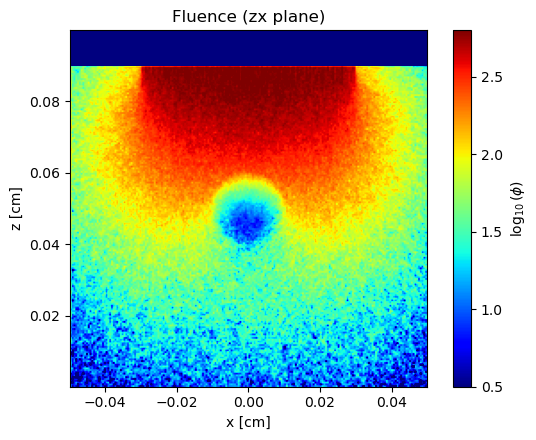

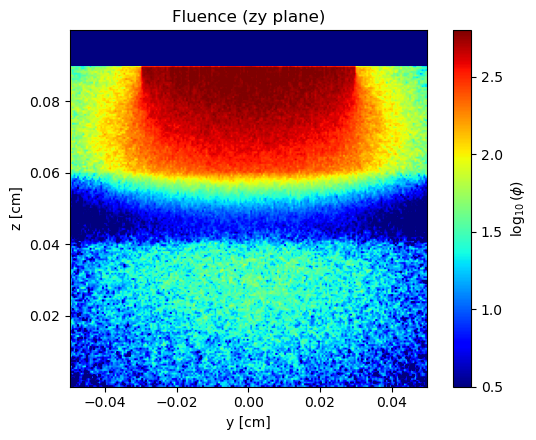

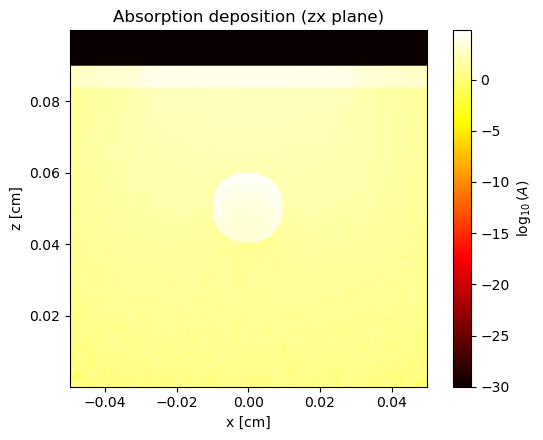

In [21]:
look_mcxyz('skinvessel', nm, savepics=True)